## Import libraries

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from   matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob
from scipy.ndimage import rotate, shift
from scipy.ndimage import label
import scipy.ndimage as ndi

from tqdm import tqdm
from sklearn import metrics

In [31]:
base_path='dataset/'
# Loading JSON data
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

In [32]:
# Reading files
training_challenges =  load_json(base_path +'arc-agi_training_challenges.json')
training_solutions =   load_json(base_path +'arc-agi_training_solutions.json')

evaluation_challenges =load_json(base_path +'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path +'arc-agi_evaluation_solutions.json')

test_challenges =  load_json(base_path +'arc-agi_test_challenges.json')

All datasets have 400 (training and evaluation) or 100 (test) JSON tasks:

In [33]:
print(f'Number of training challenges = {len(training_challenges)}')

Number of training challenges = 400


In [34]:
print(f'Number of training solutions = {len(training_solutions)}')

Number of training solutions = 400


In [35]:
print(f'Number of evaluation challenges = {len(evaluation_challenges)}')

Number of evaluation challenges = 400


In [36]:
print(f'Number of evaluation solutions = {len(evaluation_solutions)}')

Number of evaluation solutions = 400


In [37]:
print(f'Number of test challenges = {len(test_challenges)}')

Number of test challenges = 100


The names of the first fife "training challenges" are shown below:

In [38]:
for i in range(5):
    t=list(training_challenges)[i]
    task=training_challenges[t]
    print(f'Set #{i}, {t}')

Set #0, 007bbfb7
Set #1, 00d62c1b
Set #2, 017c7c7b
Set #3, 025d127b
Set #4, 045e512c


In each task, there are **two** dictionary keys, **train** and **test**. We learn the pattern from the train input-output pairs, and then apply the pattern to the test input, to predict an output.

In [39]:
task = training_challenges['007bbfb7']
print(task.keys())

dict_keys(['test', 'train'])


Tasks have multiple train input-output pairs. Most tasks have a single test input-output pair, although some have more than one.

In [40]:
n_train_pairs = len(task['train'])
n_test_pairs = len(task['test'])

print(f'task contains {n_train_pairs} training pairs')
print(f'task contains {n_test_pairs} test pairs')

task contains 5 training pairs
task contains 1 test pairs


Dive into the first train input-output pair, we can see the grids are expressed as 2d lists with integers 0-9:

In [41]:
display(task['train'][0]['input'])
display(task['train'][0]['output'])

[[0, 7, 7], [7, 7, 7], [0, 7, 7]]

[[0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7]]

### Function to plot input/output pairs of a task

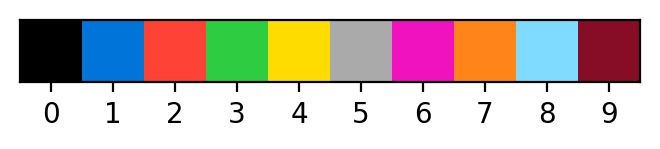

In [42]:
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

plt.figure(figsize=(4, 1), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [43]:
def plot_task(task, task_solutions, i, t):
    """    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app    """    
    
    num_train = len(task['train'])
    num_test  = len(task['test'])
    
    w=num_train+num_test
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'Set #{i}, {t}:', fontsize=20, fontweight='bold', y=1)
    #plt.subplots_adjust(hspace = 0.15)
    #plt.subplots_adjust(wspace=20, hspace=20)
    
    for j in range(num_train):     
        plot_one(axs[0, j], j,'train', 'input')
        plot_one(axs[1, j], j,'train', 'output')        
    
    
    plot_one(axs[0, j+1], 0, 'test', 'input')


    answer = task_solutions
    input_matrix = answer
    
    axs[1, j+1].imshow(input_matrix, cmap=cmap, norm=norm)
    axs[1, j+1].grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    axs[1, j+1].set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    axs[1, j+1].set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    axs[1, j+1].set_xticklabels([])
    axs[1, j+1].set_yticklabels([])
    axs[1, j+1].set_title('Test output')

    axs[1, j+1] = plt.figure(1).add_subplot(111)
    axs[1, j+1].set_xlim([0, num_train+1])
    
    for m in range(1, num_train):
        axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color = 'black')
    
    axs[1, j+1].plot([num_train,num_train],[0,1],'-', linewidth=3, color = 'black')

    axs[1, j+1].axis("off")

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
   
    plt.tight_layout()
    
    print(f'#{i}, {t}') # for fast and convinience search
    plt.show()  
    
    print()
    print()
    
    
def plot_one(ax, i, train_or_test, input_or_output):
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    
    ax.set_title(train_or_test + ' ' + input_or_output)

# Visualization Training set

#0, 007bbfb7


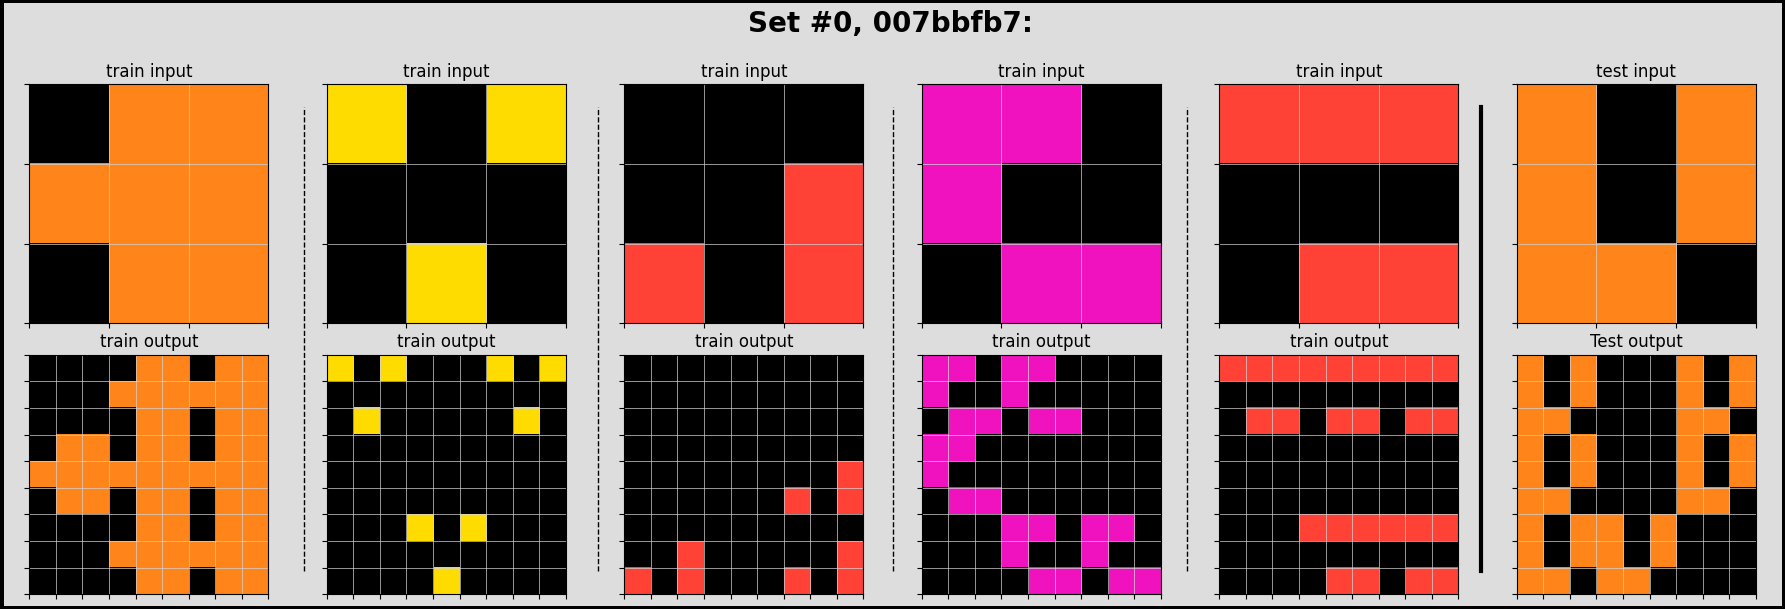

In [44]:
for i in range(0,20):
    t=list(training_challenges)[i]
    task=training_challenges[t]
    task_solution = training_solutions[t][0]
    plot_task(task,  task_solution, i, t)
    break

# Visualization Evaluating set

#0, 00576224


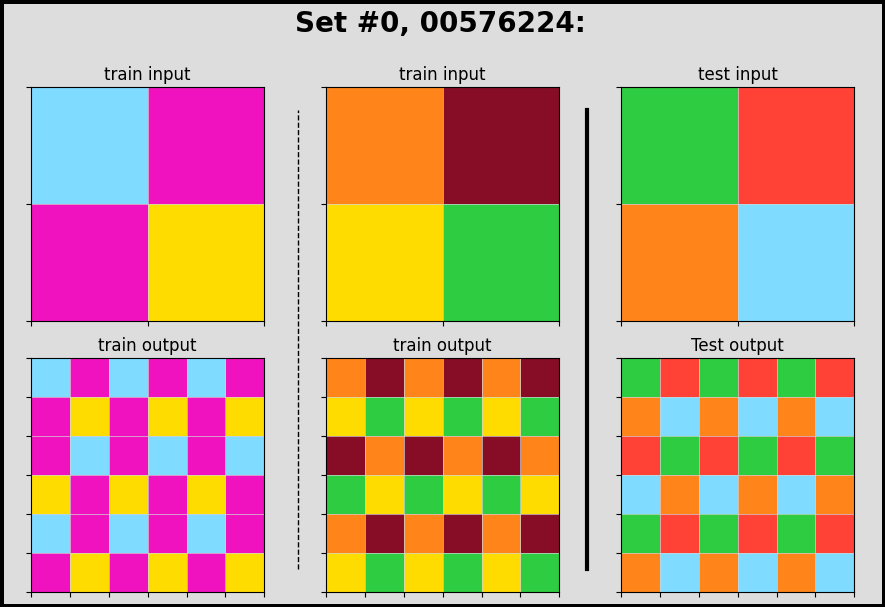

In [45]:
for i in range(0,20):
    t=list(evaluation_challenges)[i]
    task=evaluation_challenges[t]
    task_solution = evaluation_solutions[t][0]
    plot_task(task,  task_solution, i, t)
    break

In [46]:
##GEOMETRY

# 1. Do nothing
def do_nothing(matrix):
    return matrix

# 2. Rotate / Mirror / Shift Image
def rotate_image_90(matrix):
    return np.array(np.rot90(matrix, k=3))

def rotate_image_270(matrix):
    return np.array(np.rot90(matrix, k=1))

def mirror_image_horizontally(matrix):
    return np.fliplr(matrix)

def mirror_image_vertical(matrix):
    return np.flipud(matrix)

def shift_image_wrap(matrix): #need to check if output after each iteration
    matrix = np.array(matrix)
    _, cols = matrix.shape
    shifted_matrices = []
    for i in range(cols):
        shifted_matrix = np.roll(matrix, shift=1, axis=1)
        shifted_matrices.append(shifted_matrix.copy())
        matrix = shifted_matrix
    return matrix

# 3. Crop image background 
def crop_background(matrix):
    matrix = np.array(matrix)
    #np.ix gives submatrix, 
        # any(1) returns non zero row, 
        # any(0) gives non zero column
    return matrix[np.ix_(matrix.any(1), matrix.any(0))] 

# 4. Draw border
def draw_border(matrix, border_size=1): #check after every iteration for output
    matrix = np.array(matrix)
    for border_value in range(10):
        matrix[:border_size, :] = border_value
        matrix[-border_size:, :] = border_value
        matrix[:, :border_size] = border_value
        matrix[:, -border_size:] = border_value
    return matrix

In [47]:
##OBJECT
# 6. Move two objects together
def process_and_concatenate_objects(matrix):
    matrix = np.array(matrix)
    # labeled_matrix, num_features = label(matrix)
    # objects = []
    # for i in range(1, num_features + 1):
    #     object_mask = (labeled_matrix == i) 
    #     object_mask = np.array(object_mask)
    #     object  = object_mask * matrix
    #     objects.append(object)
    # objects.sort(key=lambda x: len(x), reverse=True)
    # largest_mask = objects[0]
    # smaller_mask = objects[-1]
    # largest_coords = np.argwhere(largest_mask)
    # smaller_coords = np.argwhere(smaller_mask)
    # largest_min_row, largest_min_col = largest_coords.min(axis=0)
    # smaller_min_row, smaller_min_col = smaller_coords.min(axis=0)
    # row_offset = largest_min_row - smaller_min_row
    # col_offset = largest_min_col - smaller_min_col
    # result_matrix = np.zeros_like(matrix)
    # try:
    #     result_matrix[largest_mask] = matrix[largest_mask]
    # except:
    #     return matrix
    # for coord in smaller_coords:
    #     new_row = coord[0] + row_offset
    #     new_col = coord[1] + col_offset
    #     if 0 <= new_row < matrix.shape[0] and 0 <= new_col < matrix.shape[1]:
    #         result_matrix[new_row, new_col] = matrix[coord[0], coord[1]]
    return matrix

# 7. Move objects to edge
def move_objects_top_edge(matrix):
    matrix = np.array(matrix)
    rows, cols = np.nonzero(matrix)
    if len(rows) == 0 and len(cols) == 0:
        return matrix 
    min_row, max_row = np.min(rows), np.max(rows) + 1
    min_col, max_col = np.min(cols), np.max(cols) + 1
    obj = matrix[min_row:max_row, min_col:max_col]
    new_matrix = np.zeros_like(matrix)
    new_matrix[:obj.shape[0], :obj.shape[1]] = obj
    return new_matrix

def move_objects_bottom_edge(matrix):
    matrix = np.array(matrix)
    rows, cols = np.nonzero(matrix)
    if len(rows) == 0 and len(cols) == 0:
        return matrix 
    min_row, max_row = np.min(rows), np.max(rows) + 1
    min_col, max_col = np.min(cols), np.max(cols) + 1
    obj = matrix[min_row:max_row, min_col:max_col]
    new_matrix = np.zeros_like(matrix)
    new_matrix[-obj.shape[0]:, :obj.shape[1]] = obj
    return new_matrix


# 8. Extend / Repeat object
def extend_object_to_boundary(matrix):
    matrix = np.array(matrix)
    # object_mask = (matrix != 0)
    # labeled_objects, num_objects = label(object_mask)
    # extended_matrix = np.zeros_like(matrix)
    # for obj_label in range(1, num_objects + 1):
    #     object_region = labeled_objects == obj_label
    #     object_slice = ndi.find_objects(object_region)[0]
    #     row_min, row_max = object_slice[0].start, object_slice[0].stop
    #     col_min, col_max = object_slice[1].start, object_slice[1].stop
    #     extended_matrix[row_min:row_max, :] = np.maximum(extended_matrix[row_min:row_max, :], matrix[row_min:row_max, col_min:col_max].max())
    #     extended_matrix[:, col_min:col_max] = np.maximum(extended_matrix[:, col_min:col_max], matrix[row_min:row_max, col_min:col_max].max())
    # return extended_matrix
    return matrix

# 9. Delete an object
def delete_object_largest(matrix):
    # labeled_matrix, num_features = label(matrix)
    # objects = []
    # matrix = np.array(matrix)
    # for i in range(1, num_features + 1):
    #     object_mask = (labeled_matrix == i) 
    #     object_mask = np.array(object_mask)
    #     object  = object_mask * matrix
    #     objects.append(object)
    # # sort properly
    # objects.sort(key=lambda x: len(x))
    # largest_mask = objects[-1]
    # matrix[largest_mask] = 0
    return matrix

def delete_object_smaller(matrix):
    # labeled_matrix, num_features = label(matrix)
    # objects = []
    # matrix = np.array(matrix)
    # for i in range(1, num_features + 1):
    #     object_mask = (labeled_matrix == i) 
    #     object_mask = np.array(object_mask)
    #     object  = object_mask * matrix
    #     objects.append(object)
    # # sort properly
    # objects.sort(key=lambda x: len(x))
    # smaller_mask = objects[0]
    # matrix[smaller_mask] = 0
    return matrix

# 11. Overlay object
def overlay_object(matrix):
    matrix =np.array(matrix)
    return matrix

# 12. Replace objects
def replace_objects(matrix):
    return matrix

In [48]:
##COLORING
# 13. change color to same for all non zero values
def select_colors_for_objects(matrix): #check for each loop
    matrix = np.array(matrix)
    rows, cols = np.nonzero(matrix)
    for i in range(1, 10):  # loop values from 1 to 9
        for r, c in zip(rows, cols):
            matrix[r, c] = i
    return matrix

# 14. keep most dominant and least dominant color
def dominant_color(matrix):
    matrix = np.array(matrix)
    non_zero_values = matrix[matrix != 0]
    if non_zero_values.size == 0:  # Check if there are any non-zero values
        return np.zeros_like(matrix)
    unique, counts = np.unique(non_zero_values, return_counts=True)
    most_frequent = unique[np.argmax(counts)]
    result = np.where(matrix == most_frequent, most_frequent, 0)
    return result

def least_color(matrix):
    matrix = np.array(matrix)
    non_zero_values = matrix[matrix != 0]
    if non_zero_values.size == 0:  # Check if there are any non-zero values
        return np.zeros_like(matrix)
    unique, counts = np.unique(non_zero_values, return_counts=True)
    least_frequent = unique[np.argmin(counts)]
    result = np.where(matrix == least_frequent, least_frequent, 0)
    return result

# 15. Denoise
def denoise(matrix):
    matrix = np.array(matrix)
    for threshold in range(1,10,1):
        mask = matrix > threshold
    return np.where(mask, matrix, 0)

# 16. Fill in empty spaces
def fill_empty_spaces(matrix):
    matrix = np.array(matrix)
    mask = matrix != 0
    for fill_value in range(1,10,1):
        new_matrix = np.where(mask, matrix, fill_value)
    return new_matrix


In [49]:
##LINES
# 17. Color edges
def color_edges(matrix):
    matrix = np.array(matrix)
    edges = np.gradient(matrix)
    for edge_value in range(1,10,1):
        colored_matrix = np.copy(matrix)
        colored_matrix[edges[0] != 0] = edge_value
        colored_matrix[edges[1] != 0] = edge_value
    return colored_matrix

# 18. Extrapolate a straight/diagonal line
def extend_longest_vertical_sequence(matrix):
    matrix = np.array(matrix)
    rows, cols = matrix.shape
    longest_streak = 0
    longest_streak_col = -1
    best_start = -1
    best_end = -1
    for col in range(cols):
        streak = 0
        start_row = -1 
        for row in range(rows):
            if (matrix[row, col] != 0) and (matrix[row, col] == matrix[row-1, col]):
                if streak == 0:
                    start_row = row-1
                streak += 1
            else:
                if streak > longest_streak:
                    longest_streak = streak
                    longest_streak_col = col
                    best_start = start_row
                    best_end = row - 1
                streak = 0
        if streak > longest_streak:
            longest_streak = streak
            longest_streak_col = col
            best_start = start_row
            best_end = rows - 1
        if longest_streak != -1:
            matrix[:best_start, longest_streak_col] = matrix[best_start, longest_streak_col]
            matrix[best_end+1:, longest_streak_col] = matrix[best_start, longest_streak_col]
    return matrix

def extend_longest_horizontal_sequence(matrix):
    matrix = np.array(matrix)
    rows, cols = matrix.shape
    longest_streak = 0
    longest_streak_row = -1
    best_start = -1
    best_end = -1
    for row in range(rows):
        streak = 0
        start_col = -1 
        for col in range(cols):
            if (matrix[row, col] != 0) and (matrix[row, col] == matrix[row, col-1]):
                if streak == 0:
                    start_col = col-1
                streak += 1
            else:
                if streak > longest_streak:
                    longest_streak = streak
                    longest_streak_row = row
                    best_start = start_col
                    best_end = col - 1
                streak = 0
        if streak > longest_streak:
            longest_streak = streak
            longest_streak_row = row
            best_start = start_col
            best_end = cols - 1
        if longest_streak != -1:
            matrix[longest_streak_row, :best_start] = matrix[longest_streak_row, best_start]
            matrix[longest_streak_row, best_end+1:] = matrix[longest_streak_row, best_start]
    return matrix

# 19. Draw a line between two dots
def draw_line_between_horizontal(matrix):
    matrix = np.array(matrix)
    rows, cols = matrix.shape
    new_matrix = np.copy(matrix)
    for col in range(cols):
        start_row, start_col = -1, -1 
        val = 0 
        for row in range(rows):
            if val == 0: 
                if matrix[row, col] != 0:
                    val = matrix[row, col]
                    start_row, start_col = row, col 
            elif matrix[row, col] == val:  
                if start_row != -1 and start_col != -1:
                    new_matrix[start_row + 1:row, start_col] = val 
                start_row, start_col = row, col  
            elif matrix[row, col] != 0:  
                break
    return new_matrix

def draw_line_between_vertical(matrix):
    matrix = np.array(matrix)
    rows, cols = matrix.shape
    new_matrix = np.copy(matrix)
    for col in range(cols):
        start_row, start_col = -1, -1 
        val = None
        for row in range(rows):
            if val is None: 
                if matrix[row, col] != 0:  
                    val = matrix[row, col]
                    start_row, start_col = row, col 
            elif matrix[row, col] == val:
                if start_row != -1 and start_col != -1:
                    if row - start_row > 1:
                        new_matrix[start_row + 1:row, start_col] = val  
                start_row, start_col = row, col  
            elif matrix[row, col] == 0: 
                continue  
            elif matrix[row, col] != 0:  
                break  
    return new_matrix

# 20. Draw a spiral
def draw_spiral(matrix):
    return matrix


In [50]:
##GRIDS
# 21. Select grid squares with most pixels
def select_grid_with_most_pixels(matrix):
    matrix = np.array(matrix)
    grid_sums = []
    for k in range(1,matrix.shape[0], 1):
        for i in range(0, matrix.shape[0]-k+1,k):
            for j in range(0, matrix.shape[1]-k+1,k):
                grid = matrix[i:i+k, j:j+k]
                grid_sums.append((np.sum(grid), i, j, k))
    new_matrix = np.zeros_like(matrix)
    _, max_i, max_j, max_k = max(grid_sums)
    new_matrix[max_i: max_i+max_k, max_j:max_j+max_k] = matrix[max_i: max_i+k, max_j:max_j+k]
    return new_matrix

In [51]:
##PATTERNS
# 22. Complete a symmetrical/repeating pattern
def complete_pattern_row(matrix):
    matrix = np.array(matrix)
    new_matrix = np.concatenate([matrix, np.flip(matrix, axis=0)], axis=0)
    return new_matrix

def complete_pattern_col(matrix):
    matrix = np.array(matrix)
    new_matrix = np.concatenate([matrix, np.flip(matrix, axis=1)], axis=1)
    return new_matrix

In [52]:
##SUBTASKS
# 23. Object detection / cohesion / separation
def detect_objects(matrix):
    matrix = np.array(matrix)
    unique_objects = np.unique(matrix)
    return {obj: np.argwhere(matrix == obj) for obj in unique_objects if obj != 0}

# 24. Object persistence (to track objects across frames)
# CODE

# 25. Counting or sorting objects
def count_objects(matrix):
    unique, counts = np.unique(matrix, return_counts=True)
    return dict(zip(unique, counts))

def plot_output(matrix):
    plt.imshow(matrix, cmap=cmap, norm=norm)
    plt.grid(True, which='both', color='lightgrey', linewidth=0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])


In [53]:
function_list = [
    do_nothing,
    rotate_image_90,
    rotate_image_270,
    mirror_image_horizontally,
    mirror_image_vertical,
    shift_image_wrap,
    crop_background,
    draw_border,
    
    process_and_concatenate_objects,
    move_objects_top_edge,
    move_objects_bottom_edge,
    extend_object_to_boundary,
    delete_object_largest,
    delete_object_smaller,  
    overlay_object, #incomplete
    replace_objects, #incomplete
    
    select_colors_for_objects,
    dominant_color,
    least_color,
    denoise,
    fill_empty_spaces,
    
    color_edges,
    extend_longest_vertical_sequence,
    extend_longest_horizontal_sequence,
    draw_line_between_horizontal,
    draw_line_between_vertical,
    draw_spiral, #incomplete
    
    complete_pattern_row,
    complete_pattern_col
]

In [54]:
def update_submission_json(set_number, result, attempt_num=1, file_path='submission.json'):
    if os.path.exists(file_path):
        with open(file_path, 'r') as json_file:
            try:
                data = json.load(json_file)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}
    if set_number not in data:
        data[set_number] = []
    if isinstance(result, np.ndarray):
        result = result.tolist()
    attempt_key_1 = f"attempt_{attempt_num}"
    attempt_key_2 = f"attempt_{attempt_num + 1}"
    attempts = {attempt_key_1: result, attempt_key_2: result}
    data[set_number].append(attempts)
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [55]:
def get_confusion_matrix(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
    cm_display.plot()
    plt.show()
    
class ExitLoops(Exception):
    pass

def check_on_other_training(task, func):
    for set in range(len(task)):
        input = task[set]['input']
        output = task[set]['output']
        result = func(input)
        if not (np.array_equal(output, result)):
            return True
    return False

#44, 22eb0ac0


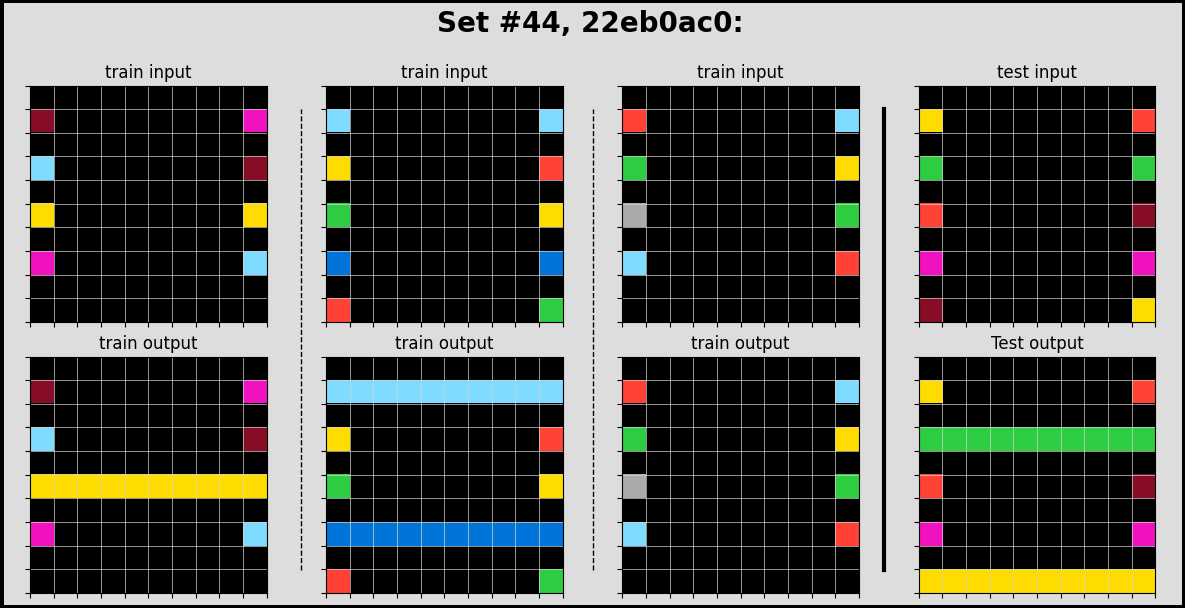



#49, 253bf280


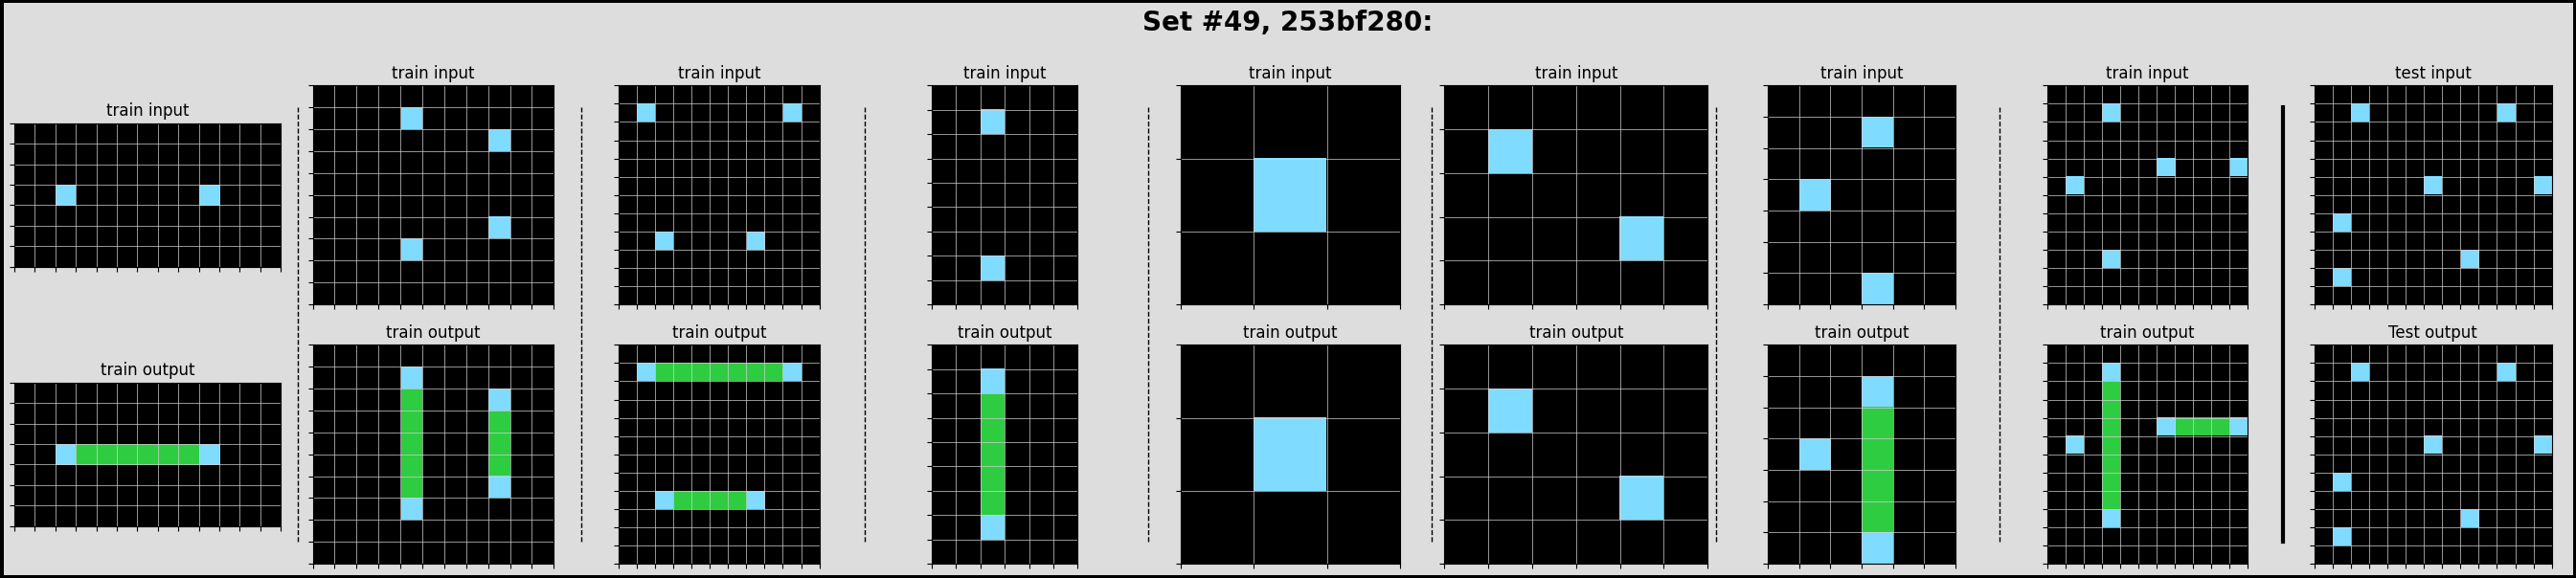



#52, 25ff71a9


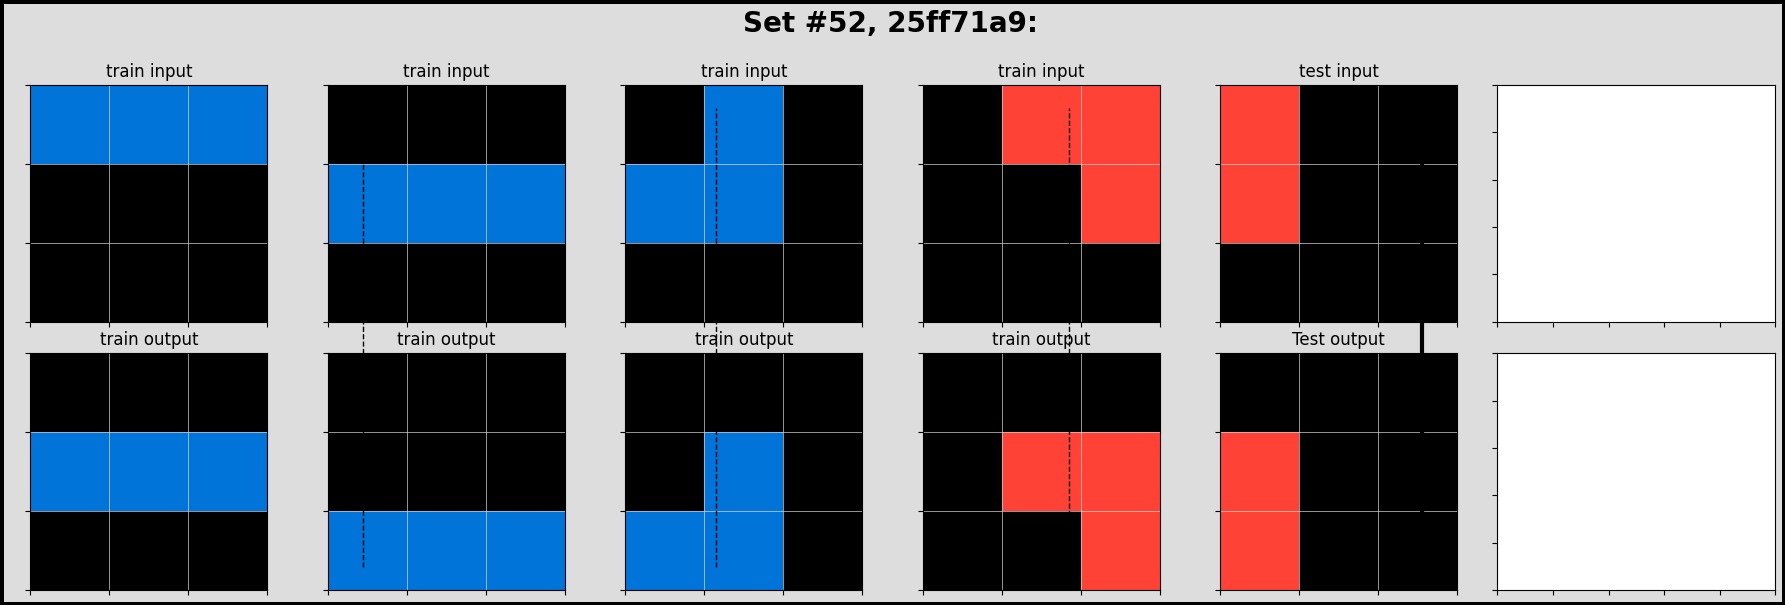

In [56]:
test_data = test_challenges
labels = ['Correct', 'Incorrect']
confusion_matrix = pd.DataFrame(0, index=labels, columns=labels)

def find_function_from_training(test, i, first_key):
    task = test_data[first_key]['train']
    try:
        for set in range(len(task)):
            input = task[set]['input']
            output = task[set]['output']
            for func in function_list:
                input = np.array(input)
                result_train = func(input)
                # plot_task(test, result_train, i, first_key)
                if np.array_equal(output, result_train):
                    if not check_on_other_training(task, func):
                        confusion_matrix.loc['Incorrect', 'Correct'] +=1
                        raise ExitLoops
                    test_set= test_data[first_key]['test']
                    test_input = test_set[0]['input']
                    test_output = func(test_input)
                    plot_task(test, test_output, i, first_key)
                    confusion_matrix.loc['Correct', 'Correct'] += 1
                    update_submission_json(first_key, test_output, 1)
                    raise ExitLoops
        update_submission_json(first_key, result_train, 1)
        confusion_matrix.loc['Incorrect', 'Incorrect'] += 1
    except ExitLoops:
        pass

for i in range(len(test_data)):
    t=list(test_challenges)[i]
    task=test_challenges[t]
    task_solution = find_function_from_training(task, i, t)

In [57]:
confusion_matrix

,Correct,Incorrect
Correct,3,0
Incorrect,1,96


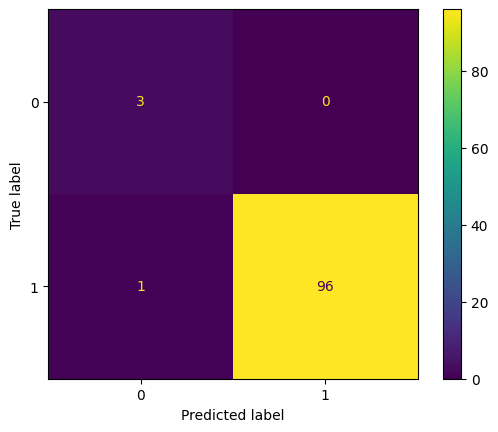

In [58]:
confusion_matrix_array = confusion_matrix.values
get_confusion_matrix(confusion_matrix_array)